In [49]:
import pint
import os
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn')

# Extra unit definitions
ureg = pint.UnitRegistry()
ureg.define('dollar = 1')
ureg.define('hash = 1')
ureg.define('block = 1')
ureg.define('btc = 1')



## Introduction
Purpose of this notebook is to walk through the evaluation of capital expenditure on mining equipment, and evaluate the economics.  Particular focus would be identifying a competitive fuel gas cost and evaluate this over the life of the project.

## Methodology
We can evaluate the project using a net present value calculation. 

$NPV = \sum_{t=1}^n {R_t \over {(1+i)}^t}$

Where:

$R_t = \text{Net cash inflow-outflows during a single period t}$

$i = \text{Discount rate or return that could be earned in alternative investments}$

$t = \text{Number of time periods}$

## Progress Notes

This is coming along pretty well.  I have a way to generate parameterized NPV calculations / charts and I'm storing these values in a dataframe.  I have a function + dataframe for the difficulty calculation.

What are the next steps?
1. Continue the write up + narrative.  
2. Implement the reward calculation





# Time Period
The time period could be days, months, quarters, years, etc.  But for our calculations let's use months.

In [16]:
def diff_func(d_now, t, r = 0.0075):
    '''
    Difficulty function used to estimate the difficulty t days in the future based on the current difficulty d_now
    parameter r is given from medium link above.
    
    E.G.
    x = np.linspace(1, 365, num = 365)
    y = diff_func(14363025673660, x)
    print(diff_func(14363025673660, 10))
    plt.plot(x,y);
    '''
    return d_now * (1 + r)**t

def btc_day(hashrate, network_hashrate, block_reward, fees):
    '''
    Calculate the approximate number of btc mined per day based on your hashrate, the network hashrate, the block reward and the fees / day
    '''
    # By some magic, on average a block is mined every 10 minutes.  Producing 144 blocks per day
    blocksperday = (1 * ureg.block / (10 * ureg.min)) * (60 * ureg.min / ureg.hour) * (24 * ureg.hour / ureg.day)
    # Extra step needed here for unit conversion
    ret = (hashrate / network_hashrate) * ((block_reward * blocksperday) + fees)
    return ret.to('btc/day')

def timetofindblock(difficulty, hashrate):
    '''
    This is a way to estimate your time to mine a block based on your hashrate and the current difficulty.  Which is another way to derive your daily revenue.  
    I think it's not as accurate because the difficulty always lags the network hashrate.
    '''
    return (difficulty * 2**32) / hashrate

def implied_hashrate(difficulty, s):
    '''
    Function to calculate the network hashrate based on a given difficulty
    '''
    return (1 / 7158278) * (s / difficulty)

def miner_revenue(th):
    '''
    Function to calculate the dollar value return per day per TH
    '''
    return 0.3 * th * ureg.dollar / ureg.day / ureg.terahash
    
#diff_func(14363025673660, 0.0075, 1)
#print(btc_day(hashrate, network_hashrate, block_reward, avg_fees))
#round(timetofindblock(difficulty, hashrate).to('sec') * (ureg.min / (60 * ureg.sec)) * (ureg.hour / (60 * ureg.min)) * (ureg.day / (24 * ureg.hour)))
#secperday = print(60 * ureg.sec / ureg.min * 60 * ureg.min / ureg.hour * 24 * ureg.hour / ureg.day);


408.8%## Example 1 - NPV


Avalon 1166 Pro

78 TH/s
3276 Watt

60 Kw / 3250 Watt ~ 16
$4800 = $76,800

375*30 = $11,250

Whatsminer M32

52 TH/s
3500W
$2500

60 / 3500 ~ 16
16 * 2500 = 40000

In [59]:
miner_revenue(832 * ureg.terahash)

249.6 <Unit('dollar / day')>

In [60]:
capex = []
capex.append(-40000 - 13000 - 2000)

revenue = np.ones(23) * 7600
revenue = revenue.tolist()


#capex + revenue

In [61]:
dateindex = pd.date_range(start = '2021-4-1', freq = 'M', periods = 24)
df = pd.DataFrame(data = (capex + revenue), index = dateindex, columns = ['income'])

new_list = []
net_revenue = 0

for i in df['income'].to_list():
    net_revenue += i
    new_list.append(net_revenue)

new_list = [float(ele) for ele in new_list]

df['net_revenue'] = new_list
df

,income,net_revenue
2021-04-30,-55000.0,-55000.0
2021-05-31,7600.0,-47400.0
2021-06-30,7600.0,-39800.0
2021-07-31,7600.0,-32200.0
2021-08-31,7600.0,-24600.0
2021-09-30,7600.0,-17000.0
2021-10-31,7600.0,-9400.0
2021-11-30,7600.0,-1800.0
2021-12-31,7600.0,5800.0
2022-01-31,7600.0,13400.0


In [62]:
i = 1
npv = -1
tries = df.shape[0]
df['npv_09'] = np.nan
df['npv_20'] = np.nan
df['npv_06'] = np.nan


for i in range(1, tries):
    df['npv_09'].iloc[i-1] = npf.npv(0.091, df['income'].iloc[:i])
    df['npv_06'].iloc[i-1] = npf.npv(0.06, df['income'].iloc[:i])
    df['npv_20'].iloc[i-1] = npf.npv(.2, df['income'].iloc[:i])


In [63]:
df

,income,net_revenue,npv_09,npv_20,npv_06
2021-04-30,-55000.0,-55000.0,-55000.000000,-55000.000000,-55000.000000
2021-05-31,7600.0,-47400.0,-48033.913841,-48666.666667,-47830.188679
2021-06-30,7600.0,-39800.0,-41648.866948,-43388.888889,-41066.215735
2021-07-31,7600.0,-32200.0,-35796.395003,-38990.740741,-34685.109184
2021-08-31,7600.0,-24600.0,-30432.076080,-35325.617284,-28665.197343
2021-09-30,7600.0,-17000.0,-25515.193474,-32271.347737,-22986.035230
2021-10-31,7600.0,-9400.0,-21008.426649,-29726.123114,-17628.335122
2021-11-30,7600.0,-1800.0,-16877.567964,-27605.102595,-12573.901059
2021-12-31,7600.0,5800.0,-13091.263028,-25837.585496,-7805.567037
2022-01-31,7600.0,13400.0,-9620.772712,-24364.654580,-3307.138714


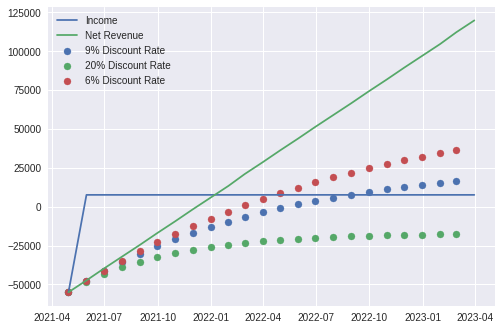

In [65]:
a =  npf.npv(0.1, df['income'])
#print("Net Present Value(npv) : ", a)

plt.plot(df['income'], label = 'Income');
plt.plot(df['net_revenue'], label = 'Net Revenue');
plt.scatter(df.index, df['npv_09'], label = '9% Discount Rate');
plt.scatter(df.index, df['npv_20'], label = '20% Discount Rate');
plt.scatter(df.index, df['npv_06'], label = '6% Discount Rate')
plt.legend();
plt.savefig('npv.png')

In [ ]:
daterange = pd.date_range(start = '2021-7-1', freq = '1D', periods = 365)
df_difficulty = pd.DataFrame(index = daterange)
df_difficulty['num'] = mdates.date2num(df_difficulty.index)
df_difficulty['diff'] = np.nan
df_difficulty['diff'].iloc[0] = 14363025673660
for x in range(1,df_difficulty.shape[0]):
    df_difficulty['diff'].iloc[x] = diff_func(df_difficulty['diff'].iloc[0], df_difficulty['num'].iloc[x] - df_difficulty['num'].iloc[0])


In [ ]:
df_difficulty

In [ ]:

plt.plot(df_difficulty['diff']);

# Miner Calculations

In [ ]:
hashrate = 100 * ureg.terahash / ureg.sec
network_hashrate = 97494534728710730000 * ureg.hash / ureg.sec
block_reward = 6.25 * ureg.btc / ureg.block
blocksperday = (1 * ureg.block / (10 * ureg.min)) * (60 * ureg.min / ureg.hour) * (24 * ureg.hour / ureg.day)
difficulty = 14363025673660 * ureg.hash
avg_fees = 90 * ureg.btc / ureg.day



In [ ]:
#Need to move this into a database and maybe do some web scraping

#Antminer S9
power = 1600 * ureg.watt
hashrate = 14 * ureg.terahash / ureg.sec
cost = 600 * ureg.dollar

print(hashrate / power)
print(hashrate / cost)

#Antminer S19J pro
power = 3250 * ureg.watt
hashrate = 104 * ureg.terahash / ureg.sec
cost = 7900 * ureg.dollar

print(hashrate / power)
print(hashrate / cost)

# Generator Calculations
So maybe the task is to write some functions to say ok this fuel cost equates to this elec rate in cents / kwh

In [ ]:
#some functions
def gencost_kwh(size, cost, lifespan):
    '''
    Gives you the cost to run a given generator in dollars / KWh
    Useful for comparison to hosting center electricity rates
    '''
    return (cost / size) / lifespan * (ureg.year / (365 * ureg.day)) * (ureg.day / (24 * ureg.hour))

# Some constants
generator_rated_load = 60 * ureg.kilowatt
generator_fuel_gas_consumption = 800 * ureg.cubic_foot / ureg.hour

#National average is something like 12 c/kwh, LA like 9 c/kwh
elec_cost = 0.10 * ureg.dollar / ureg.kilowatt_hour
elec_cost_ind = 0.065 * ureg.dollar / ureg.kilowatt_hour
#Average industrial cost for gas is something like $2-3 / mcf
fuel_cost = 1 * ureg.dollar / ureg.cubic_foot / 1000

print(generator_rated_load)
print(generator_fuel_gas_consumption)

1.001.001.00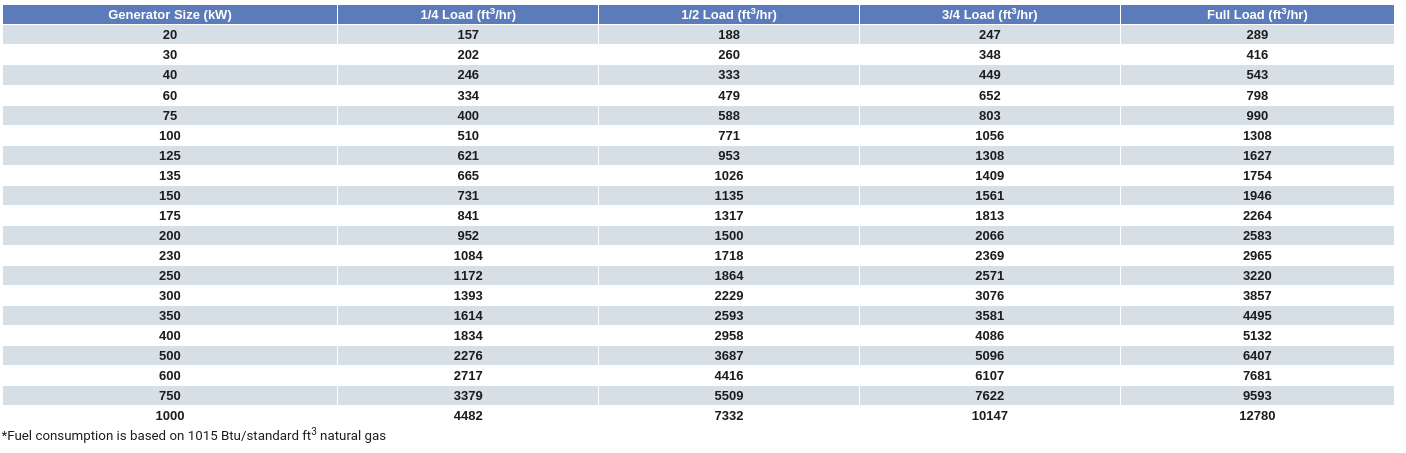

From: https://www.generatorsource.com/Natural_Gas_Fuel_Consumption.aspx'

Flaring report + Map: https://www.energy.gov/sites/prod/files/2019/08/f65/Natural%20Gas%20Flaring%20and%20Venting%20Report.pdf

In [ ]:
fuel_cost * generator_fuel_gas_consumption * (24 * ureg.hour / ureg.day) * (365 * ureg.day / ureg.year)

In [ ]:
cost_kwh.to('dollar / ( year kilowatt)') * 60

In [ ]:
#Cost to run the genny on industrial fuel gas
print(round(fuel_cost * generator_fuel_gas_consumption * 24 * ureg.hour / ureg.day * 30 * ureg.day / ureg.month))

In [ ]:
#Cost to operate the mining equipment in a hosting center
#cost = generator_rated_load * elec_cost * 24 * ureg.hour / ureg.day * 30 * ureg.day / ureg.month
#print(cost.to('dollar/month'))
cost = generator_rated_load * elec_cost_ind * 24 * ureg.hour / ureg.day * (365 * ureg.day / ureg.year)
print(round(cost.to('dollar/year')))

In [ ]:
gen_cost = 13000 * ureg.dollar
proj_lifespan = 4 * ureg.year

gencost_kwh(generator_rated_load, gen_cost, proj_lifespan)

In [ ]:
implied_hashrate(14363025673660, )

# Random Notes
Remember, you can calculate the implied network hashrate based on the difficulty:

![image.png](attachment:fe17e7ac-ece0-4d18-9310-67fdae5cb21d.png)![image.png](attachment:7cf9e4c6-cd86-4564-8533-b95b7a4ced6d.png)

From: https://medium.com/chainalysis/bitcoin-mining-calculations-ff90dc958dba



$\text{BTC per day} = {\text{hashrate} \over \text{network hashrate}}  \left( {\text{block reward} \over \text{blocks per day}} + \text{Network Fees} \right)$

${\text{BTC} \over \text{block}}{ 1 \over \text{time to mine a block}}$

${\text{BTC} \over \text{block}} {\text{your hash rate} \over \text{difficulty} * 2^{32}}$

1. Difficulty Function
2. btc_day Function
3. Time to find a block